In [7]:
#we define an "incremented pd_code" if it is of the form (a, b, a+1, b+1) or (a, b+1, a+1, b). This is achieved by walking around the knot and labelling each new 'strand'
#with an incrementing indexing number as you pass over or under a crossing.

#method for getting an incremented pd code of a knot as a list. sage takes pd_code lists as inputs for knots.
def knot_from_table(k,n):
    import snappy
    def sage_pd_code(link):
        pd = link.PD_code()
        return [[element + 1 for element in tup] for tup in pd]
    L = snappy.Link(str(k) + '_' + str(n))
    snappd = sage_pd_code(L)
    #print(snappd)
    K = Knot(snappd)
    return K

#returns the list of regions with no negative values.
def abs_regions(self):
    regions = self.regions()
    return [set(abs(element) for element in reg) for reg in regions]

#returns the pd_code as a set. Used supplementarily to aid in intersection and difference checks.
def cross(self):
    return [set(pd) for pd in self.pd_code()]

def weight(tuple, kt):
    if kt == 'TypeI':
        if int(tuple[2]) % 2 == 1:
            return +1
        else:
            return -1
    else:
        if int(tuple[2]) % 2 == 1:
            return -1
        else:
            return +1

#returns the complement of two sets' intersection.
def complement_intersection(set1, set2):
    return set(set1).difference(set2)

#returns the length of the intersection of two sets. used primarily for the weights of the crossings, as a set is unordered.
def common_elements(lst, s):
    list_set = set(lst)
    common = list_set.intersection(s)
    return len(common)

#quick graph
def decorate_and_plot_graph(g):
    if g.has_multiple_edges() == False:
        plot = g.plot(layout = 'planar', dist = 0.15, iterations = 200, edge_labels=True)
    else:
        plot = g.plot(layout = 'spring', dist = 0.15, iterations = 200, edge_labels=True)
    plot.show(figsize = 6)

#quick graph where red represents positive crossings
def color_and_plot_graph(g):
    red_edges = [e for e in g.edge_iterator() if e[2] == 1]
    g.plot(edge_color='blue', edge_colors={'red': red_edges}).show(figsize = 6)

def knot_type(pd_code):
    Z2_list = [[p % 2 for p in c] for c in pd_code]
    typeI = [[0, 0, 1, 1], [1, 1, 0, 0]]
    typeII = [[0,1,1,0],[1,0,0,1]]
    if all(c in typeI for c in Z2_list) == True:
        return 'TypeI', Z2_list
    else:
        zero_count = sum(1 for t in Z2_list if t == typeII[0])
        #print(f"There are {zero_count} crossings of the form [0,1,1,0]")
        one_count = sum(1 for t in Z2_list if t == typeII[1])
        #print(f"There are {one_count} crossings of the form [1,0,0,1]")
        return 'TypeII', Z2_list

def abs_list_of_lists(lists):
    return [[abs(element) for element in sublist] for sublist in lists]

def abs_regions_list(self):
    regions = self.regions()
    return [[abs(element) for element in reg] for reg in regions]

In [2]:
import sage.graphs.graph as graph

def tait_graph(K, debug = False, weight_debug = False):
    regions_as_list = abs_list_of_lists(K.regions()) 
    regions = abs_regions(K)
    crossings = cross(K)
    pd_code = K.pd_code()
    faces_static = {index: tuple(region) for index, region in enumerate(regions)}
    faces_static_list = {index: region for index, region in enumerate(regions_as_list)}
    faces = {tuple(region): index for index, region in enumerate(regions)}
    edges = []
    seen = []

    if debug:
        print(f"faces_static_list: {faces_static_list}")
        print(f"pd_code: {pd_code}")

    # TODO: implement the directed edge from the silver-williams paper.

    for ind in range(len(faces)):
        common_list = [c for c in crossings if len(set(faces_static[ind]).intersection(c)) == 2]

        set_diff = [complement_intersection(c, faces_static[ind]) for c in common_list]

        neighboring_regions = [(key, value) for key, value in faces_static.items() for s in set_diff if len(set(value).intersection(s)) == 2]
 
        neighboring_regions_list = [region for region in regions_as_list for s in set_diff if len(set(region).intersection(s)) == 2]

        #TODO implement handling of R1 and self loops
        #TODO implement finding the white graph when interior R1 moves are present

        for i in range(len(neighboring_regions)):
            if neighboring_regions[i][1] not in seen:
                #print(f"Drawing edge from {(faces[faces_static[ind]])} (region {[faces_static[ind]]}) to {neighboring_regions[i][0]} (region {neighboring_regions[i][1]}) with weight {weight_list[i]}")
                edges.append((faces[faces_static[ind]], neighboring_regions[i][0], weights(pd_code, faces_static_list[ind], neighboring_regions_list[i])))
        seen.append(faces_static[ind])
    G = graph.Graph(edges, multiedges=True, loops = True)
    components = G.connected_components()
    if len(components) > 2:
        raise ValueError('The link diagram is split.')
    return G.subgraph(components[0]), G.subgraph(components[1])

In [3]:
#find pd_code such that the union of region and neighboring region intersect with pd_code is exactly of length 4
def find_pd_code(pd_code, region, neighboring_region):
    combined = set(region).union(set(neighboring_region))
    for pd in pd_code:
        if len(combined.intersection(set(pd))) == 4:
            return pd

def matches_cyclic_order(corner, crossing):
    n = len(crossing)
    for i in range(n):
        if crossing[i] == corner[0] and crossing[(i + 1) % n] == corner[1]:
            return True
    return False

def weights(pd_code, region, neighboring_region, debug = False):
    #the set of cyclic pairs for a region. can think of it as the corners of the crossings as one walks counter clockwise around the region
    #turning left at each crossing
    cyclic_pairs = [[region[i], region[(i + 1) % len(region)]] for i in range(len(region))]
    
    crossing = find_pd_code(pd_code, region, neighboring_region)

    corner = [c for c in cyclic_pairs if len(set(c).intersection(set(crossing))) == 2]

    if len(corner) > 1:
        # Find the corner that matches the order in the crossing list
        corner = [corner for corner in corner if matches_cyclic_order(corner, crossing)]
    
    if debug:
        print(f"region: {region}, neighboring_region: {neighboring_region}")
        print(f"crossing: {crossing}")
        print(f"corner: {corner}")

    """
    check the index of the first value in the cyclic pairs list for each cyclic pair and see which strand it is in the pd_code
    the first element in a cyclic pair is the 'incoming' strand that forms the region
    if the corresponding index is 0 or 2, then it is the understrand, and thus the overstrand passes from left to right
    and the crossing is positive. if the index is 1 or 3, then it is a component of the overstrand, and the overstrand
    passes right to left and the crossing is negative
    """

    index_of_crossing = crossing.index(corner[0][0])    
    if index_of_crossing == 0 or index_of_crossing == 2:
        return 1
    else:
        return -1
# TODO: implement the directed edge from the silver-williams paper.



In [4]:
#adding edge graphs to csv

from sage.all_cmdline import *   # import sage library
from sage.knots.link import *
from sage import *

_sage_const_0 = Integer(0); _sage_const_1 = Integer(1)
import ast
import sage.all as sage
import pandas as pd

# Read the CSV file
df = pd.read_csv("/home/cawilson1/REU2024/REU2024-2/knot_info_inc_PD.csv", sep=';')

def tait_graph(pd):
    # Ensure pd is a proper list
    if isinstance(pd, str):
        import ast
        try:
            pd = ast.literal_eval(pd)
        except Exception as e:
            raise ValueError(f"Error converting pd_code from string: {e}")

    if not isinstance(pd, list):
        raise ValueError("pd_code must be a list.")
    
    for sublist in pd:
        if not isinstance(sublist, list):
            raise ValueError("Each element of pd_code must be a list.")
        for item in sublist:
            if not isinstance(item, int):
                raise ValueError("Each item in pd_code must be an integer.")
    try:
        K = Knot(pd)
    except Exception as e:
        print(f"Error initializing Knot: {e}")
        return []
    K = Knot(list(pd))
    regions_as_list = abs_list_of_lists(K.regions()) 
    regions = abs_regions(K)
    crossings = cross(K)
    pd_code = K.pd_code()
    faces_static = {index: tuple(region) for index, region in enumerate(regions)}
    faces_static_list = {index: region for index, region in enumerate(regions_as_list)}
    faces = {tuple(region): index for index, region in enumerate(regions)}
    edges = []
    seen = []

    # TODO: implement the directed edge from the silver-williams paper.

    for ind in range(len(faces)):
        common_list = [c for c in crossings if len(set(faces_static[ind]).intersection(c)) == 2]

        set_diff = [complement_intersection(c, faces_static[ind]) for c in common_list]

        neighboring_regions = [(key, value) for key, value in faces_static.items() for s in set_diff if len(set(value).intersection(s)) == 2]
 
        neighboring_regions_list = [region for region in regions_as_list for s in set_diff if len(set(region).intersection(s)) == 2]

        #TODO implement handling of R1 and self loops
        #TODO implement finding the white graph when interior R1 moves are present

        for i in range(len(neighboring_regions)):
            if neighboring_regions[i][1] not in seen:
                #print(f"Drawing edge from {(faces[faces_static[ind]])} (region {[faces_static[ind]]}) to {neighboring_regions[i][0]} (region {neighboring_regions[i][1]}) with weight {weight_list[i]}")
                edges.append((faces[faces_static[ind]], neighboring_regions[i][0], weights(pd_code, faces_static_list[ind], neighboring_regions_list[i])))
        seen.append(faces_static[ind])
    #G = graph.Graph(edges, multiedges=True, loops = True)
    #components = G.connected_components()
    #if len(components) > 2:
    #    raise ValueError('The link diagram is split.')
    #return G.subgraph(components[0]), G.subgraph(components[1])
    return edges

# Initialize counter
counter = _sage_const_0 

df['edge_graph'] = None

# Apply the function to the 'incr_pd_notation' column and store the results in 'edge_graph'
nan_values = ~df['incr_pd_notation'].isna()  # Identify NaN values in 'incr_pd_notation' column
for idx, val in df.loc[nan_values, 'incr_pd_notation'].items():
    df.at[idx, 'edge_graph'] = tait_graph(val)
    counter += _sage_const_1 
    print(f"Processed {counter} knots")

# Output debug information
print("Processing completed.")

#df.loc[nan_values, 'Type'] = df[nan_values].incr_pd_notation.apply( lambda x : knot_type(x))

# Save the DataFrame to CSV
df.to_csv("/home/cawilson1/REU2024/REU2024-2/knot_info_inc_PD_with_tait_graphs.csv", sep=';', index=False)

Processed 1 knots
Processed 2 knots
Processed 3 knots
Processed 4 knots
Processed 5 knots
Processed 6 knots
Processed 7 knots
Processed 8 knots
Processed 9 knots
Processed 10 knots
Processed 11 knots
Processed 12 knots
Processed 13 knots
Processed 14 knots
Processed 15 knots
Processed 16 knots
Processed 17 knots
Processed 18 knots
Processed 19 knots
Processed 20 knots
Processed 21 knots
Processed 22 knots
Processed 23 knots
Processed 24 knots
Processed 25 knots
Processed 26 knots
Processed 27 knots
Processed 28 knots
Processed 29 knots
Processed 30 knots
Processed 31 knots
Processed 32 knots
Processed 33 knots
Processed 34 knots
Processed 35 knots
Processed 36 knots
Processed 37 knots
Processed 38 knots
Processed 39 knots
Processed 40 knots
Processed 41 knots
Processed 42 knots
Processed 43 knots
Processed 44 knots
Processed 45 knots
Processed 46 knots
Processed 47 knots
Processed 48 knots
Processed 49 knots
Processed 50 knots
Processed 51 knots
Processed 52 knots
Processed 53 knots
Pr

In [7]:
#plotting graphs to

import pandas as pd
from sage.graphs.graph import Graph
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import ast

def decorate_and_plot_graph(edges, name):
    g = Graph(edges, multiedges = True)
    # SageMath plots can be saved to a file instead of a Matplotlib figure
    plot_file = f"/tmp/{name}.png"
    red_edges = [e for e in g.edge_iterator() if e[2] == 1]
    g.plot(edge_color='blue', edge_colors={'red': red_edges}, title=str(name)).save(plot_file)
    return plot_file

def save_all_graphs_to_pdf(csv_file, output_pdf):
    # Read the CSV file
    df = pd.read_csv(csv_file, delimiter=';')
    
    # Create a PdfPages object to save all plots in a single PDF
    with PdfPages(output_pdf) as pdf:
        # Iterate through the rows of the DataFrame
        for index, row in df.iterrows():
            name = row['Name']
            edges = ast.literal_eval(row['edge_graph'])  # Convert string representation of list to list
            
            # Generate and save the plot
            plot_file = decorate_and_plot_graph(edges, name)
            
            # Read the saved plot into Matplotlib and save to PDF
            img = plt.imread(plot_file)
            fig, ax = plt.subplots(figsize=(8, 6))
            ax.imshow(img)
            ax.axis('off')  # Hide axes
            pdf.savefig(fig)  # Save the current figure into the PDF
            plt.close(fig)  # Close the figure to free up memory

# Usage
csv_file = '/home/cawilson1/REU2024/REU2024-2/knot_info_inc_PD_with_tait_graphs.csv'  # Path to your CSV file
output_pdf = '/home/cawilson1/REU2024/REU2024-2/all_tait_graphs_10_crossings.pdf'  # Path to the output PDF file
save_all_graphs_to_pdf(csv_file, output_pdf)

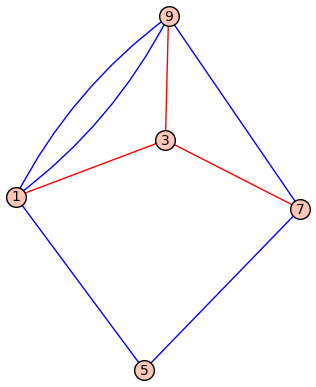

[(1, 3, 1), (1, 5, -1), (1, 9, -1), (1, 9, -1), (3, 7, 1), (3, 9, 1), (5, 7, -1), (7, 9, -1)]

In [8]:
K = knot_from_table(8,20)
black, white = tait_graph(K)
color_and_plot_graph(white)
white.edges()

In [9]:
def weighted_laplacian(G):
    edge_list = G.edges()
    vertices = G.get_vertices()
    vert_list = G.vertices()
    vert_dictionary = {value: key for key, value in enumerate(vertices)}
    print(vert_dictionary)
    n = G.order()
    M = matrix(QQ, n, n)
    for e in edge_list:
        M[vert_dictionary[e[0]],vert_dictionary[e[1]]] += e[2]
        M[vert_dictionary[e[1]],vert_dictionary[e[0]]] += e[2]
        M[vert_dictionary[e[0]],vert_dictionary[e[0]]] -= e[2]
        M[vert_dictionary[e[1]],vert_dictionary[e[1]]] -= e[2]
    return M

def reduced_weighted_laplacian(M, i):
    return M.delete_rows([i]).delete_columns([i])

L = weighted_laplacian(white)
R = reduced_weighted_laplacian(L, 0)
print(R.det())

{1: 0, 3: 1, 5: 2, 7: 3, 9: 4}
-9


In [20]:
#adding edge graphs to csv

from sage.all_cmdline import *   # import sage library
from sage.knots.link import *
from sage import *
import sage.graphs.graph as graph

_sage_const_0 = Integer(0); _sage_const_1 = Integer(1)
import ast
import sage.all as sage
import pandas as pd

# Read the CSV file
df = pd.read_csv("/home/cawilson1/REU2024/REU2024-2/knot_info_inc_PD_with_white_tait_graphs.csv", sep=';')

def weighted_laplacian_det(edges):
    print(edges)
    G = graph.Graph(edges, multiedges=True, loops = True)
    vertices = G.get_vertices()
    vert_list = G.vertices()
    vert_dictionary = {value: key for key, value in enumerate(vertices)}
    #print(vert_dictionary)
    n = G.order()
    M = matrix(QQ, n, n)
    for e in edge_list:
        M[vert_dictionary[e[0]],vert_dictionary[e[1]]] += e[2]
        M[vert_dictionary[e[1]],vert_dictionary[e[0]]] += e[2]
        M[vert_dictionary[e[0]],vert_dictionary[e[0]]] -= e[2]
        M[vert_dictionary[e[1]],vert_dictionary[e[1]]] -= e[2]
    reduced_weighted_laplacian = M.delete_rows([0]).delete_columns([i])
    return abs(reduced_weighted_laplacian.det())


# Initialize counter
counter = _sage_const_0 

#df['white_edge_graph'] = None
df['det_white_graph'] = None

# Apply the function to the 'incr_pd_notation' column and store the results in 'edge_graph'
nan_values = ~df['white_edge_graph'].isna()  # Identify NaN values in 'incr_pd_notation' column
for idx, val in df.loc[nan_values, 'white_edge_graph'].items():
    df.at[idx, 'det_white_graph'] = weighted_laplacian_det(val)
    counter += _sage_const_1 
    print(f"Processed {counter} knots")

# Output debug information
print("Processing completed.")

#df.loc[nan_values, 'Type'] = df[nan_values].incr_pd_notation.apply( lambda x : knot_type(x))

# Save the DataFrame to CSV
df.to_csv("/home/cawilson1/REU2024/REU2024-2/white_tait_graphs_det.csv", sep=';', index=False)

[(1, 4, -1), (1, 4, -1), (1, 4, -1)]


RuntimeError: the string seems corrupt: valid characters are 
?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_`abcdefghijklmnopqrstuvwxyz{|}~